In [115]:
import sys
import numpy as np
# import scikitlearn
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import glob

# ML Magic:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import (
    train_test_split,
    KFold
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error
)

from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    MinMaxScaler
)

# Local includes:
sys.path.append("../../src/")
import therm_params as tp
from power_model import (
    leakagePower,
    peripheral_power,
    board_power
)


# Setting to make pandas show floats in non-scientific notation:
pd.options.display.float_format = '{:.3f}'.format

In [120]:
data = ["../../xu3_src/xu3_dataset_V2_1.csv"]
files = data

In [121]:
df_list = []

def leak_row_big(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_big_cluster, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)
    
def leak_row_little(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_little_cluster, \
            np.mean( [row.temp4, row.temp5, row.temp6, row.temp7, row.temp_gpu] ) + 273.15)

def leak_row_gpu(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_gpu, row.temp_gpu + 273.15 )

def leak_row_mem(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_mem, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)

def process_dataframe_list(df_list):
    data = pd.concat(df_list, ignore_index=True)
    # Drop all measurements where watts <= 0:
    data = data.loc[data.total_watts > 0]
    # fill in the potentially missing voltage values
#     data["volts_big_cluster"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000])
#     data["volts_little_cluster"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000])
    # Replace with correct value for gpu and mem voltage:
#     data["volts_gpu"] = 1.0
#     data["volts_mem"] = 1.2
    # Recompute the leakage power:
    #data['leak_big'] = data.apply(leak_row_big, axis=1)
    #data['leak_little'] = data.apply(leak_row_little, axis=1)
    #data['leak_gpu'] = data.apply(leak_row_gpu, axis=1)
    #data['leak_mem'] = data.apply(leak_row_mem, axis=1)
    #data['w_leak2'] = data.apply(lambda row: np.sum( [row.leak_big, row.leak_little, row.leak_gpu, row.leak_mem] ), axis=1)

    data_filtered = data.copy()
#     data_filtered["usage_little"] = data[["usage_c0", "usage_c1", "usage_c2", "usage_c3"]].apply(func = np.sum, axis=1)
    data_filtered["usage_big"] = data[["usage_c4", "usage_c5", "usage_c6", "usage_c7"]].apply(func = np.sum, axis=1)
    data_filtered["max_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.max, axis=1)
    data_filtered["avg_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.mean, axis=1)
    data_filtered["vvf_b"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000]**2 * (x/1000000000))
#     data_filtered["vvf_l"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000]**2 * (x/1000000000))
    #data_filtered["p_dyn"] = data.apply(lambda row: row.watts - row.w_leak2 - peripheral_power, axis=1)
    #data_filtered["p_big_dyn"] = data.apply(lambda row: row.w_big - row.leak_big, axis=1)
    #data_filtered["aVVFb"] = data_filtered.apply(lambda row: row.usage_big * row.vvf_b, axis=1)
    #data_filtered["aVVFl"] = data_filtered.apply(lambda row: row.usage_little * row.vvf_l, axis=1)
    #data_filtered["gpu_mem"] = 1
    data_filtered['p_total'] = data.total_watts
    #data_filtered['p_leak'] = data.w_leak2
    # Sanity check:
#     min_p_dyn = np.min(data_filtered.p_dyn.loc[data_filtered['p_dyn'] < 0])
#     if not pd.isnull(min_p_dyn):
#         data_filtered -= min_p_dyn
    return data_filtered

In [122]:
for file in files:
    df = pd.read_csv(file, index_col=False, header=0, sep=',')
    df_list.append(df)
        
data_filtered = process_dataframe_list(df_list)
data_filtered.describe()

,total_watts,w_big,w_little,w_gpu,w_mem,usage_c4,usage_c5,usage_c6,usage_c7,temp4,temp5,temp6,temp7,temp_gpu,freq_big_cluster,usage_big,max_temp_big,avg_temp_big,vvf_b,p_total
count,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000,5415.000
mean,3.435,0.845,0.035,0.107,0.037,0.077,0.079,0.075,0.076,54.827,58.738,58.552,54.564,52.190,1331486611.265,0.308,59.668,56.670,1.724,3.435
std,1.135,0.883,0.003,0.014,0.007,0.267,0.269,0.263,0.265,8.130,9.521,9.502,8.099,6.048,471006736.983,0.461,11.045,8.538,1.167,1.135
min,2.618,0.232,0.030,0.095,0.029,0.000,0.000,0.000,0.000,48.000,51.000,51.000,48.000,47.000,900000000.000,0.000,51.000,49.500,0.770,2.618
25%,2.637,0.235,0.032,0.097,0.033,0.000,0.000,0.000,0.000,49.000,52.000,52.000,49.000,48.000,1000000000.000,0.000,52.000,50.500,0.902,2.637
50%,3.260,0.676,0.034,0.099,0.035,0.000,0.000,0.000,0.000,51.000,54.000,54.000,51.000,49.000,1000000000.000,0.000,54.000,53.000,0.902,3.260
75%,3.821,1.143,0.038,0.119,0.039,0.000,0.000,0.000,0.000,62.000,66.000,65.000,61.000,58.000,2000000000.000,1.000,66.000,63.500,3.380,3.821
max,6.935,3.503,0.050,0.151,0.068,1.000,1.000,1.000,1.000,83.000,91.000,96.000,87.000,69.000,2000000000.000,1.588,96.000,81.750,3.380,6.935


In [123]:
data_filtered.head()

,total_watts,w_big,w_little,w_gpu,w_mem,usage_c4,usage_c5,usage_c6,usage_c7,temp4,temp5,temp6,temp7,temp_gpu,freq_big_cluster,usage_big,max_temp_big,avg_temp_big,vvf_b,p_total
0,3.065,0.475,0.033,0.096,0.049,0.000,0.000,0.000,0.000,49,53,52,48,47,1000000000,0.000,53,50.500,0.902,3.065
1,2.706,0.236,0.032,0.097,0.033,0.000,0.000,0.000,0.000,48,52,52,48,47,1000000000,0.000,52,50.000,0.902,2.706
2,2.706,0.236,0.035,0.097,0.033,0.000,0.000,0.000,0.000,48,52,52,48,47,1000000000,0.000,52,50.000,0.902,2.706
3,2.637,0.235,0.035,0.096,0.038,0.000,0.000,0.000,0.000,48,51,51,48,47,1000000000,0.000,51,49.500,0.902,2.637
4,2.637,0.234,0.034,0.096,0.033,0.000,0.000,0.000,0.000,48,51,51,48,47,1000000000,0.000,51,49.500,0.902,2.637


In [124]:
model_cols = ["usage_big", "max_temp_big", "avg_temp_big", "vvf_b", "p_total"]
X = data_filtered.loc[:, model_cols]
# y = data_filtered.p_total
# Or:
# y = data_filtered.p_dyn
# Or:
y = data_filtered.w_big

# Fit and apply a scaler to the data:
# scaler = MinMaxSaler()
# scaler.fit(X)
# X = scaler.transform(X)

activator = 'relu'
alpha_r = .1
hidden_layer_sizes = (100, 60, 10)
maximum_iterations = 200
# The model:
TPM = MLPRegressor(activation=activator, alpha=alpha_r,\
                   hidden_layer_sizes=hidden_layer_sizes,\
                  random_state = 45, max_iter=maximum_iterations)
# # Create training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)#, shuffle=True) 
# Train the model:
TPM = TPM.fit(X_train, y_train)
P = TPM.predict(X_test)

In [125]:
R = TPM.score(X_test, y_test)
R

0.99266099702841171

In [126]:
mean_squared_error( list(y_test.values), list(P) )

0.0051920927451581346

In [127]:
pd.DataFrame([list(P), list(y_test.values)] )

,0,1,2,3,4,5,6,7,8,9,...,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165
0,0.689,0.902,1.170,0.241,0.238,0.237,1.185,0.694,0.240,0.792,...,1.173,0.241,1.168,1.180,1.192,0.236,0.229,0.236,0.234,0.786
1,0.676,0.703,1.131,0.236,0.235,0.234,1.155,0.677,0.235,0.700,...,1.147,0.235,1.145,1.119,1.147,0.234,0.235,0.233,0.233,0.695


Load Blackscholes Test Data and Predict the big cluster power:

In [219]:
# Load some other data and test/plot it:
f_test = "../../xu3_src/xu3_power_blackscholes_V1.csv"

to_plot = pd.read_csv(f_test, index_col=False, header=0, sep=',')
other_XY = process_dataframe_list([to_plot])

In [220]:
X_plot = other_XY.loc[:, model_cols]
# X_plot = scaler.transform(X_plot)
y_plot = other_XY.w_big
# y_plot = other_XY.p_total

In [130]:
P_plot = TPM.predict(X_plot)
TPM.score(X_plot, y_plot)

0.94249260301388538

In [131]:
mean_squared_error( list(y_plot.values), list(P_plot) )

0.078781303309792008

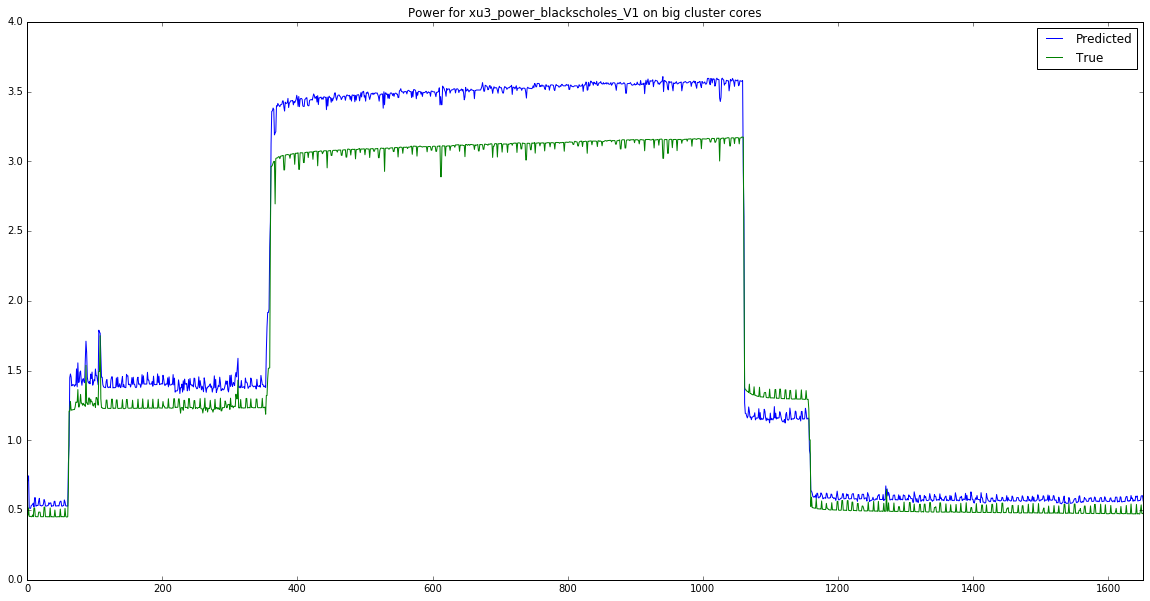

In [132]:
plt.rcParams["figure.figsize"] = [20,10]
plt.plot(range(len(P_plot)), P_plot, label="Predicted")
y_plot.plot(label="True")
plt.legend()
plt.title("Power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
plt.show()

Load bodytrack benchmark data and predict the big cluster power:

In [236]:
# Load some other data and test/plot it:
f_test = "../../xu3_src/xu3_power_bodytrack_V1.csv"

to_plot = pd.read_csv(f_test, index_col=False, header=0, sep=',')
other_XY = process_dataframe_list([to_plot])

In [237]:
X_plot = other_XY.loc[:, model_cols]
# X_plot = scaler.transform(X_plot)
y_plot = other_XY.w_big
# y_plot = other_XY.p_total

In [135]:
P_plot = TPM.predict(X_plot)
TPM.score(X_plot, y_plot)

0.91571752673615281

In [136]:
mean_squared_error( list(y_plot.values), list(P_plot) )

0.13208650462929789

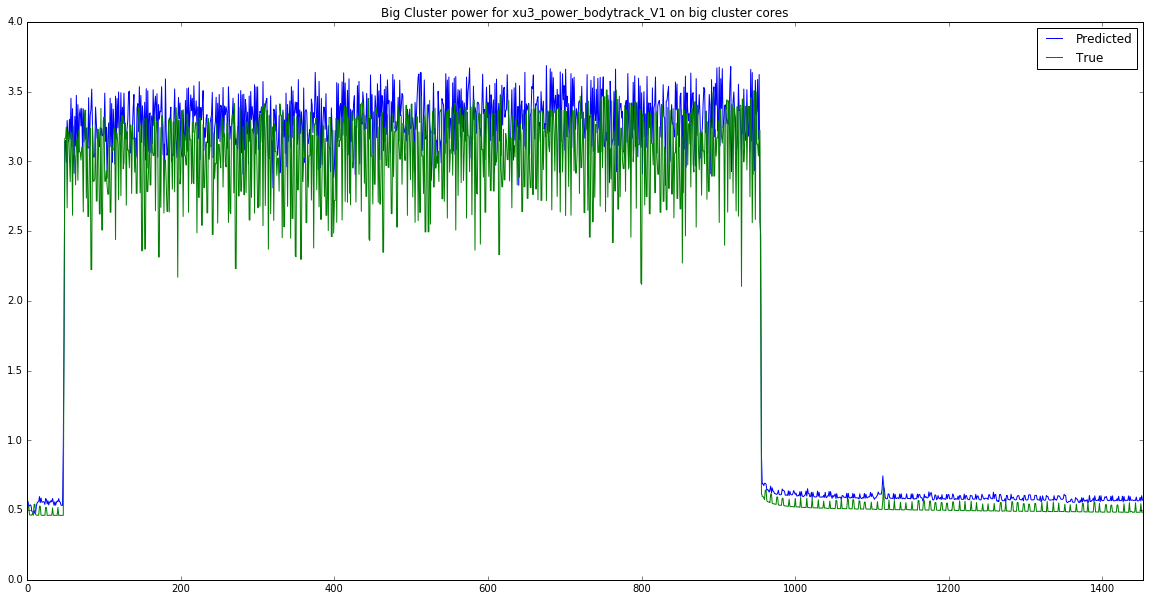

In [137]:
plt.rcParams["figure.figsize"] = [20,10]
plt.plot(range(len(P_plot)), P_plot, label="Predicted")
y_plot.plot(label="True")
plt.legend()
plt.title("Big Cluster power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
plt.show()

### Now do thermal prediction:

In [226]:
model_cols = ["temp4", "temp5", "temp6", "temp7", "usage_big", "p_total", "w_big"]
X = data_filtered.loc[0:len(data_filtered)-2, model_cols]
# note offset so we are predicting...
Y = data_filtered.loc[1:len(data_filtered),["temp4", "temp5", "temp6", "temp7"]]

# # Fit and apply a scaler to the data:
# # scaler = MinMaxSaler()
# # scaler.fit(X)
# # X = scaler.transform(X)

activator = 'relu'
alpha_r = .1
hidden_layer_sizes = (100, 60, 10)
maximum_iterations = 200
# The model:
ThermModel = MLPRegressor(activation=activator, alpha=alpha_r,\
                   hidden_layer_sizes=hidden_layer_sizes,\
                  random_state = 45, max_iter=maximum_iterations)
# # Create training and test sets:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.40, random_state=42)#, shuffle=True) 
# Train the model:
ThermModel = ThermModel.fit(X_train, Y_train)
P = ThermModel.predict(X_test)

In [227]:
ThermModel.score(X_test, Y_test)

0.99722418630862752

In [228]:
mean_squared_error( Y_test.values, P )

0.20194599553764866

In [229]:
Y_plot = Y_test.loc[:,tag].values

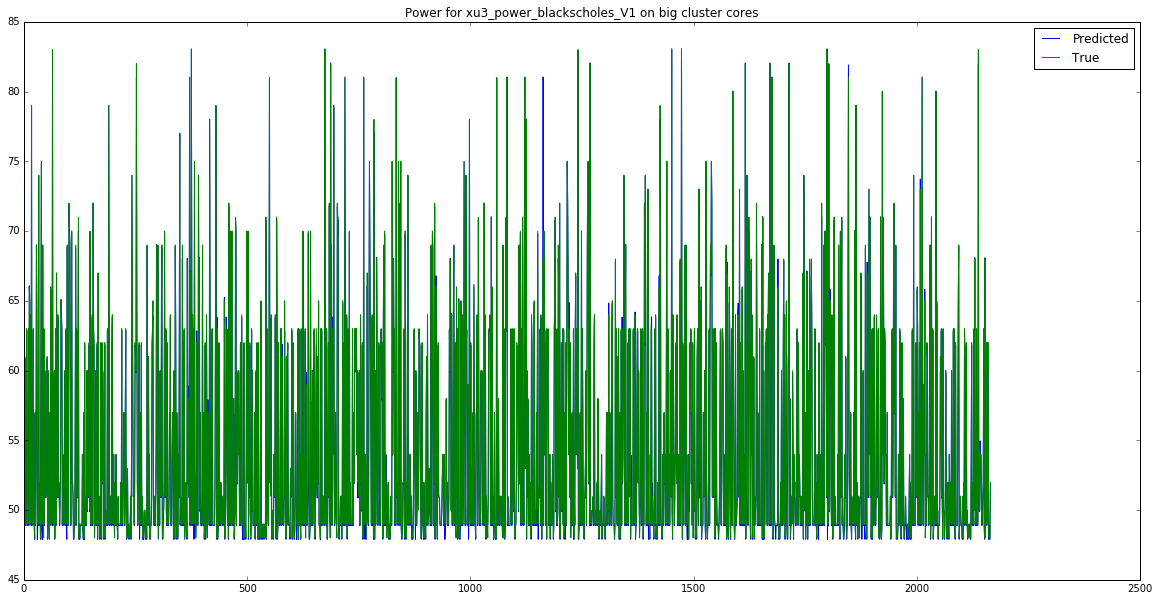

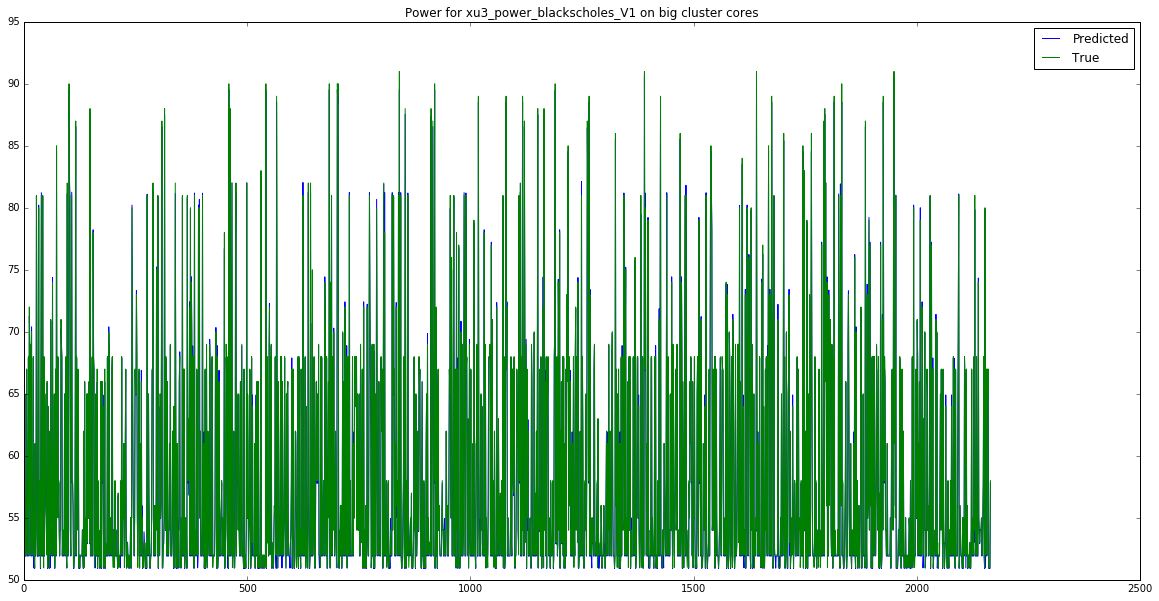

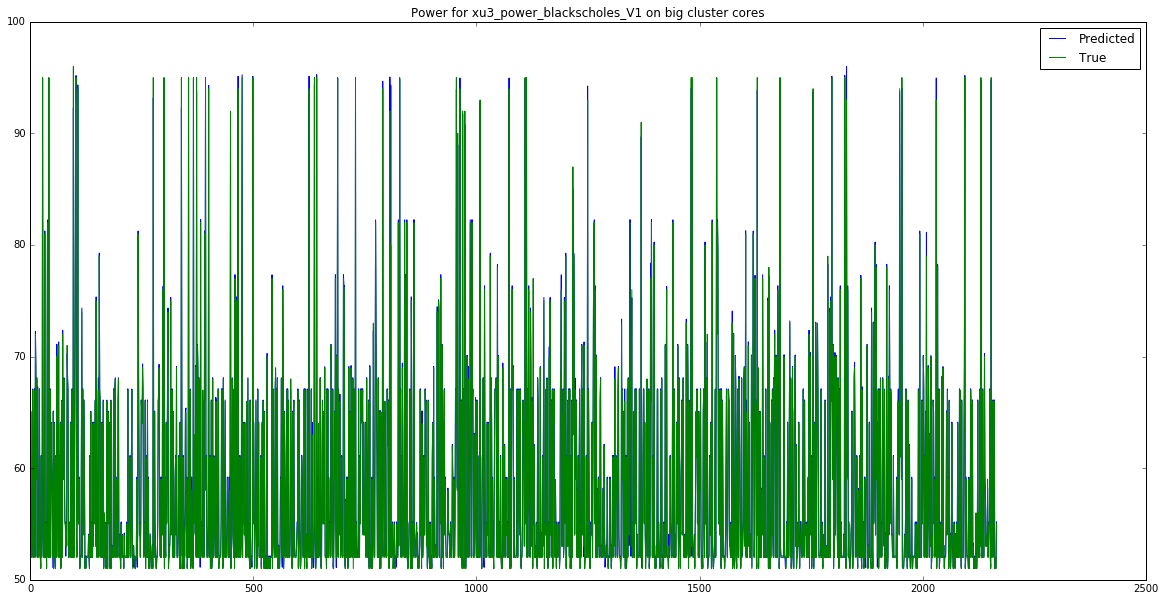

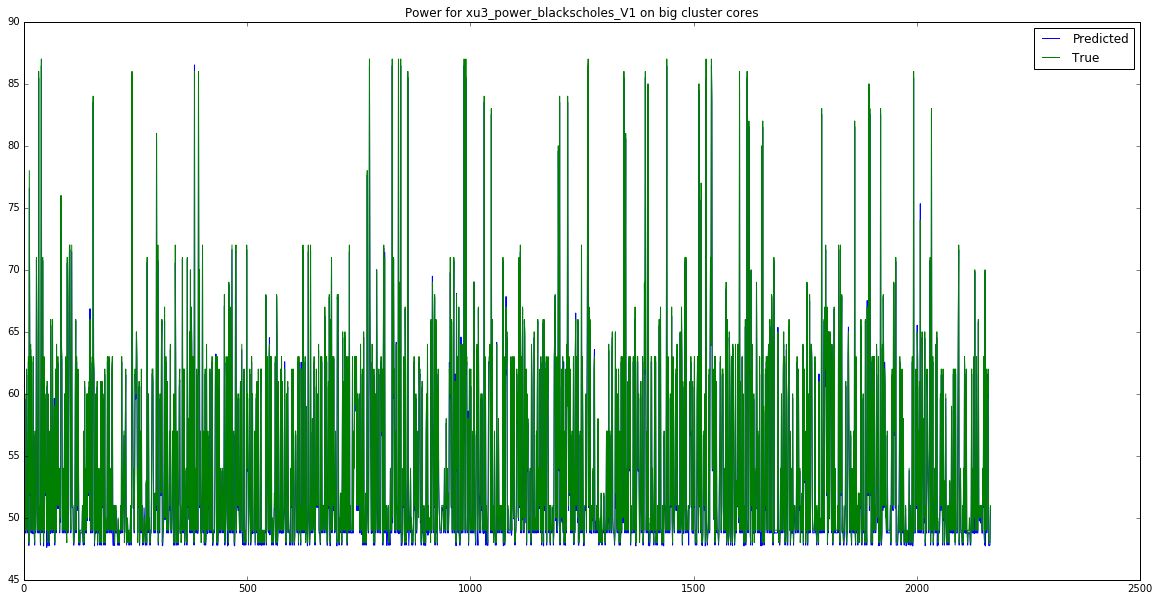

In [230]:
for k in range(4):
    tag = "temp" + str(k+4)
    Y_plot = Y_test.loc[:,tag].values
    P_plot = np.transpose(P)[k]
    plt.rcParams["figure.figsize"] = [20,10]
    plt.plot(range(len(P_plot)), P_plot, label="Predicted")
    plt.plot(range(len( Y_plot )), Y_plot, label="True")
    plt.legend()
    plt.title("Power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
    plt.show()

Validation test:

In [238]:
X_plot = other_XY.loc[0:len(other_XY)-2, model_cols]
# X_plot = scaler.transform(X_plot)
Y_plot = other_XY.loc[1:len(other_XY),["temp4", "temp5", "temp6", "temp7"]]
# y_plot = other_XY.p_total

In [239]:
P_plot = ThermModel.predict(X_plot)
ThermModel.score(X_plot, Y_plot)

0.98473147971570607

In [240]:
mean_squared_error( Y_plot.values, P_plot )

1.3200042842122239

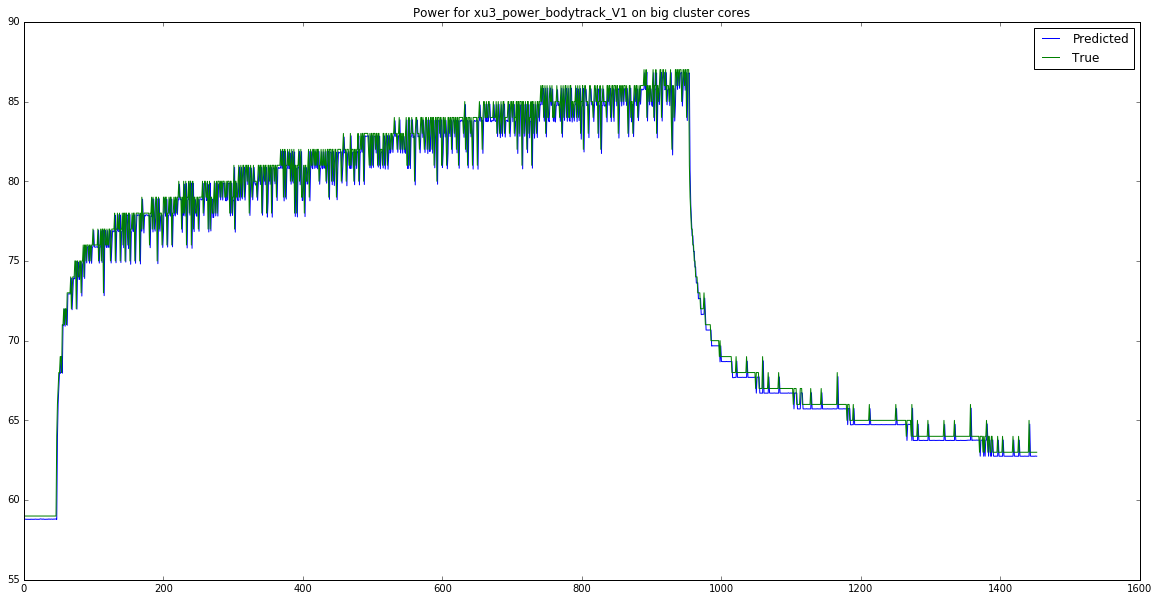

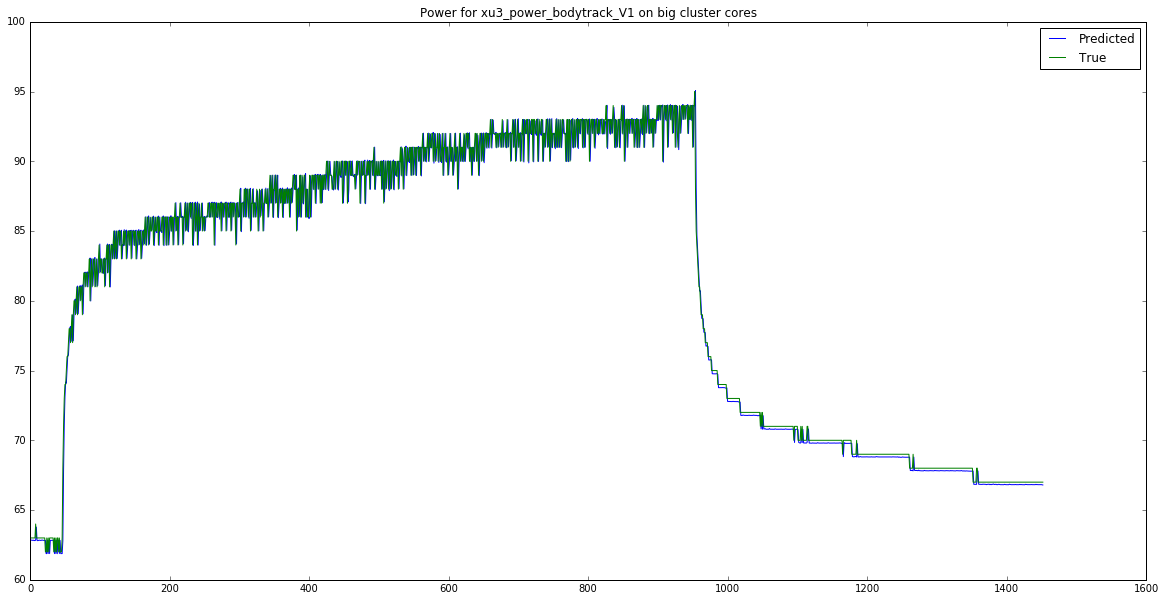

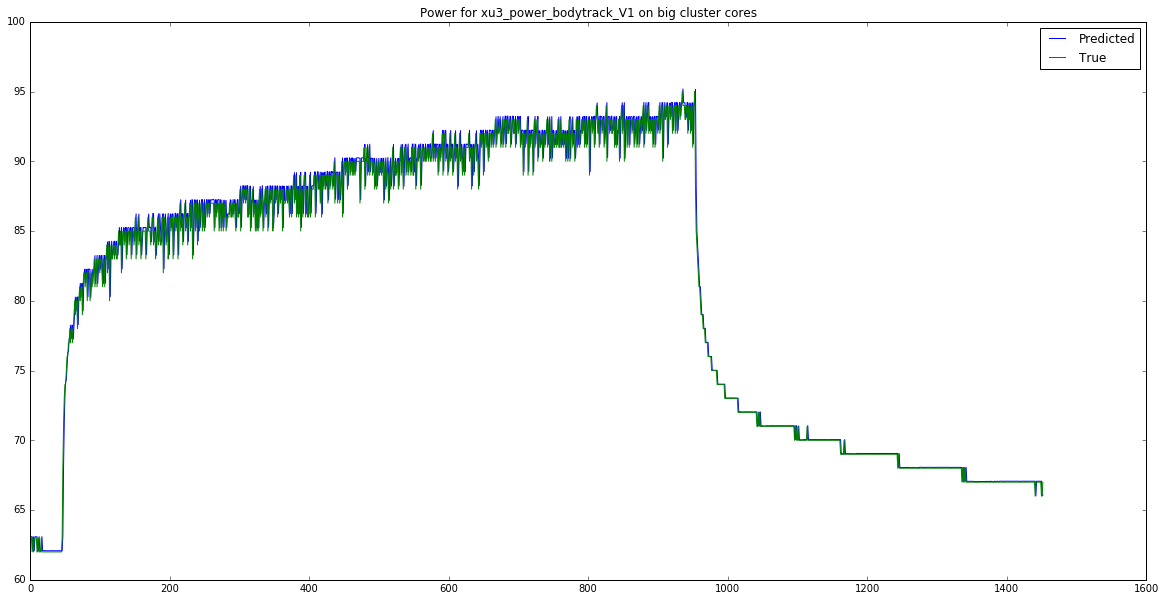

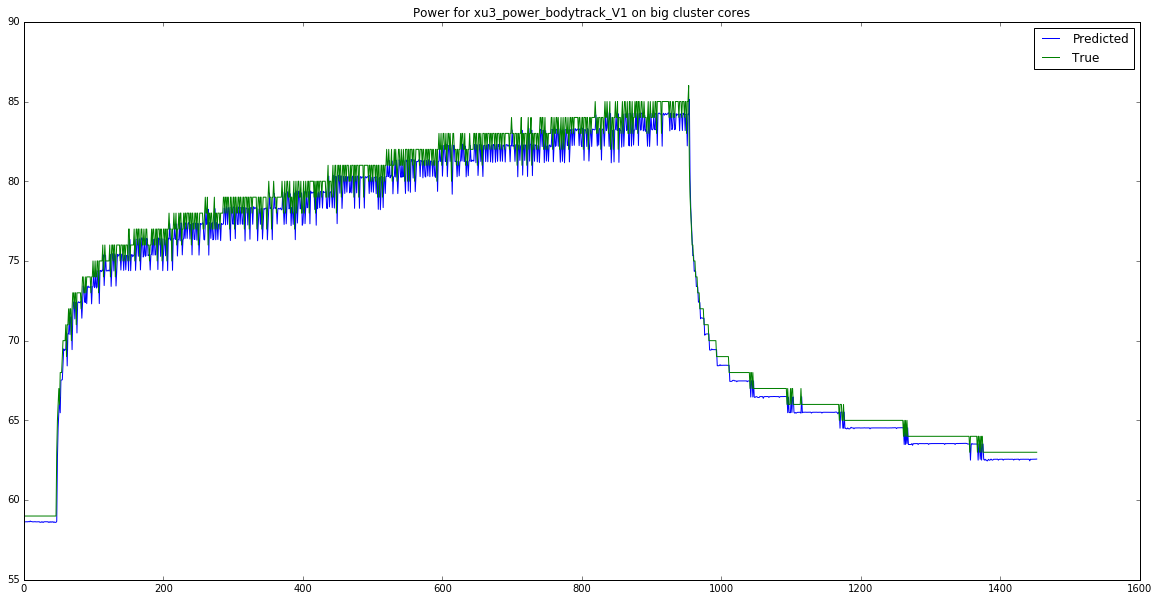

In [241]:
# plt.rcParams["figure.figsize"] = [20,10]
# plt.plot(range(len(P_plot)), P_plot, label="Predicted")
# Y_plot.plot(label="True")
# plt.legend()
# plt.title("Power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
# plt.show()


for k in range(4):
    tag = "temp" + str(k+4)
    Y_plot_k = Y_plot.loc[:,tag].values
    P_plot_k = np.transpose(P_plot)[k]
    plt.rcParams["figure.figsize"] = [20,10]
    plt.plot(range(len(P_plot_k)), P_plot_k, label="Predicted")
    plt.plot(range(len( Y_plot_k )), Y_plot_k, label="True")
    plt.legend()
    plt.title("Power for {} on big cluster cores".format(f_test[f_test.rfind('/')+1:f_test.rfind('.')]))
    plt.show()